In [1]:
!git clone https://github.com/IgorCzudy/data_visualization.git
!pip install git+https://github.com/tensorflow/docs
if not os.path.exists(f"{parent_dir}/TEAA/plots"):
  os.mkdir(f"{parent_dir}/TEAA/plots", exist_ok=True)

Cloning into 'data_visualization'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 87 (delta 34), reused 73 (delta 23), pack-reused 0
Receiving objects: 100% (87/87), 5.07 MiB | 19.28 MiB/s, done.
Resolving deltas: 100% (34/34), done.


In [2]:
from data_visualization.lab_4.helpers import *
from data_visualization.lab_4.nets import *
from data_visualization.lab_4.results_and_plots import *

In [7]:
parent_dir = '/content/drive/My Drive'
data_dir = parent_dir + '/TEAA/21x14'

formats = [
    '21x14', # 21 channels with spectrogram filtered to 8 values in the frequency domain + 6 time domain statistics: in total 294 dimensions
    'pca136', # same than previous one after applying PCA conserving 99% of variance
    'pca141' # same but using chb[1-16] for training and chb[17-24] for testing
]

configurations = [
    LabConfiguration(FEEDFORWARD, feedforward_1, to_categorical = False, epochs = 5),
    LabConfiguration(FEEDFORWARD, feedforward_2, to_categorical = True, epochs = 5),
    LabConfiguration(FEEDFORWARD, feedforward_3, to_categorical = True, epochs = 5),
    LabConfiguration(RECURRENT, rnn_1, to_categorical = True, timesteps = 10, epochs = 1),
    LabConfiguration(RECURRENT, rnn_2, to_categorical = True, timesteps = 10, epochs = 1),
    LabConfiguration(CONVOLUTIONAL, cnn_1, to_categorical = False, epochs = 5),
    LabConfiguration(CONVOLUTIONAL, cnn_2, to_categorical = True, epochs = 5),
    LabConfiguration(TDCNN, cnn_3, to_categorical = True, timesteps = 10, epochs = 10)
]

In [8]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Read 234159 lines from train set and 220863 from test set
Preprocessed data: 234159 train set 220863 test set
example data: chb16, label 1, x.shape = (294,)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 294)]             0         
                                                                 
 gaussian_noise_2 (Gaussian  (None, 294)               0         
 Noise)                                                          
                                                                 
 dense_6 (Dense)             (None, 256)               75520     
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dense_8 (Dense)             (None, 2)                 514       
                                  

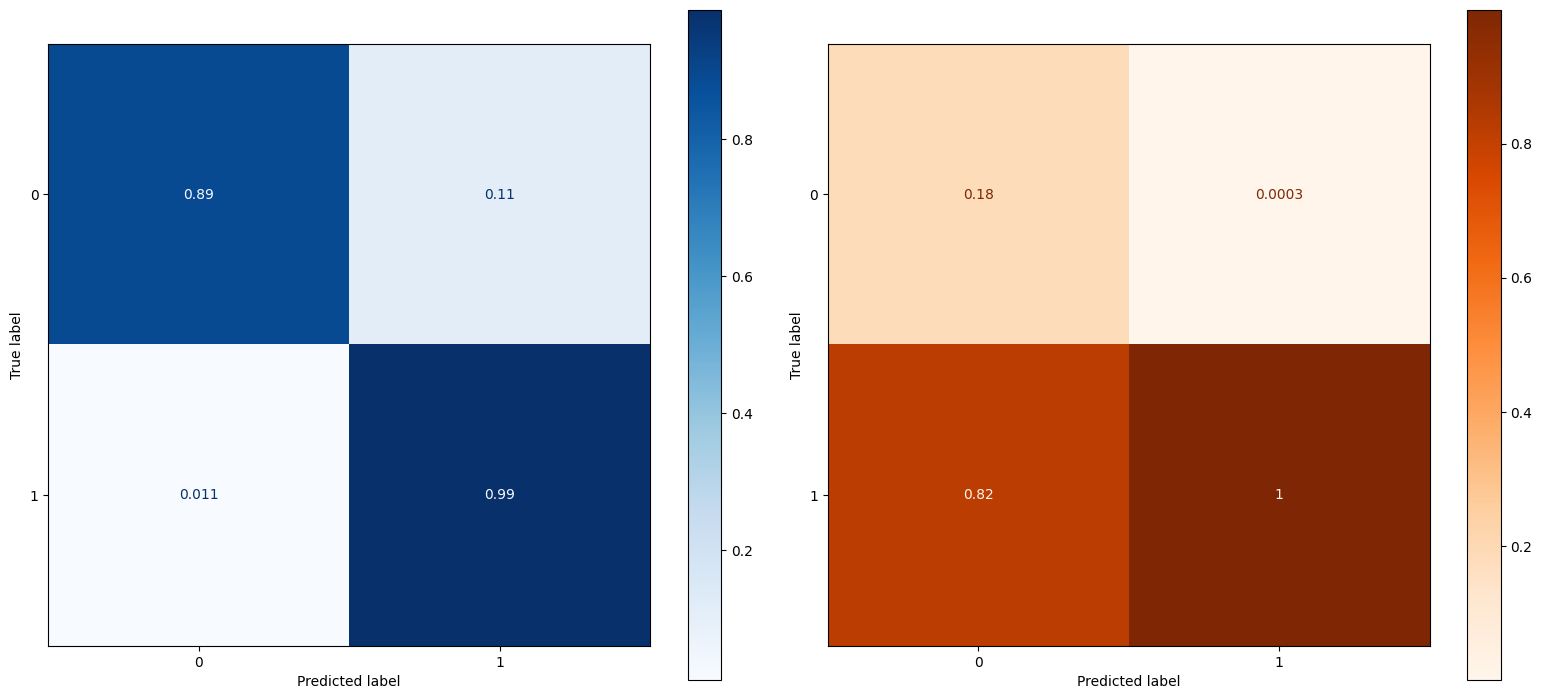

        540         253 

       8751      211319 

              precision    recall  f1-score   support

           0       0.06      0.68      0.11       793
           1       1.00      0.96      0.98    220070

    accuracy                           0.96    220863
   macro avg       0.53      0.82      0.54    220863
weighted avg       1.00      0.96      0.98    220863



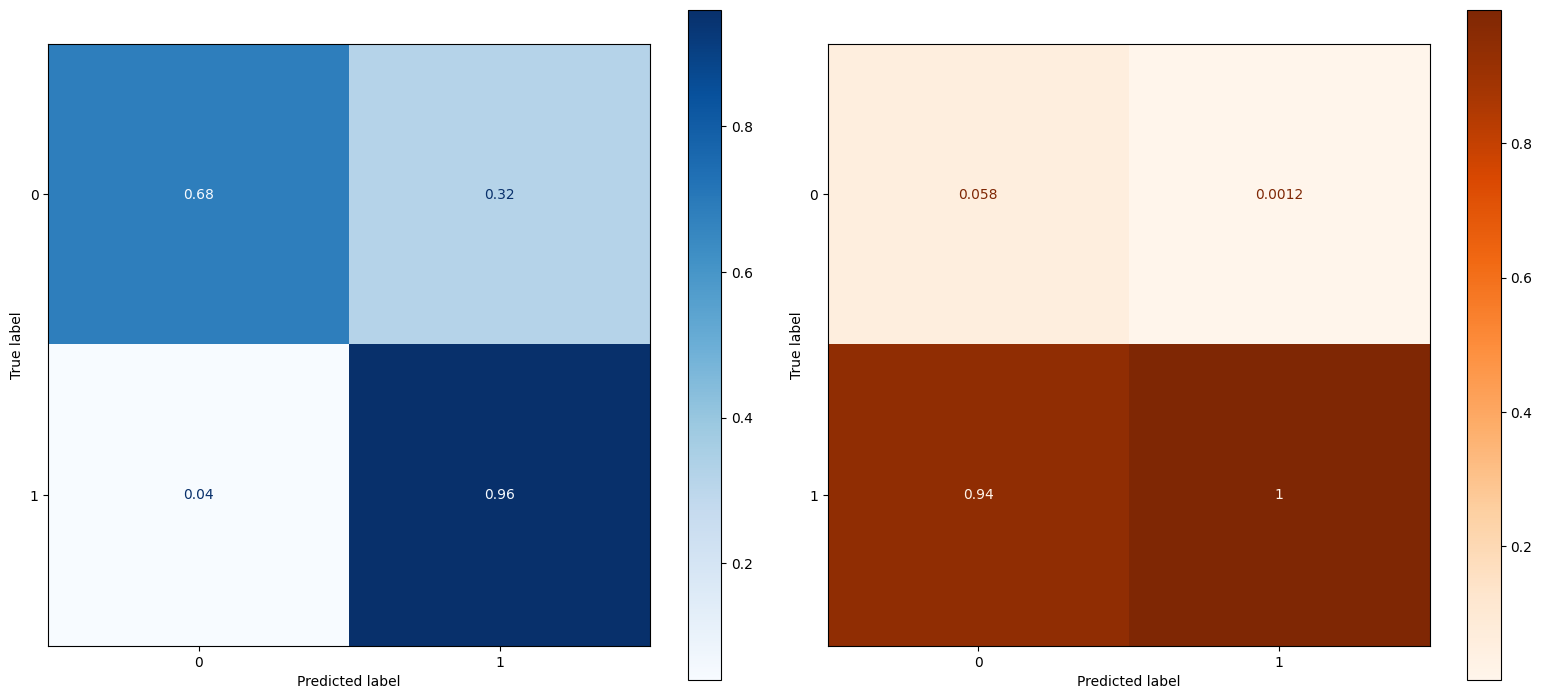

In [27]:
for format in formats:
  train_lines, test_lines = get_train_and_test_sets(format, data_dir)
  print(f"Read {len(train_lines)} lines from train set and {len(test_lines)} from test set")

  for binary_classification in [True, False]:

    # get y data
    train_set = [csv_to_tuple(l, False, binary_classification) for l in train_lines]
    test_set  = [csv_to_tuple(l, False, binary_classification) for l in test_lines]

    y_train = np.array([t[1] for t in train_set])
    y_test  = np.array([t[1] for t in test_set])
    labels = np.unique(y_train)

    class_weights = class_weight.compute_class_weight('balanced',
                                                      classes = labels,
                                                      y = y_train)
    class_weights = {i: class_weights[i] for i in range(len(class_weights))}


    for conf in configurations:
      if format != '21x24' and conf.model_type == TDCNN or conf.model_type == CONVOLUTIONAL:
        continue


      if conf.to_categorical:
        y_train = keras.utils.to_categorical(y_train, num_classes = len(labels))
        y_test  = keras.utils.to_categorical(y_test,  num_classes = len(labels))

      # get X data
      if conf.model_type == CONVOLUTIONAL:
        train_set = reshape_dataset(train_set)
        test_set = reshape_dataset(test_set)
        X_train, X_test = prepare_x(train_set, test_set, conf.model_type, convolutional = True)
        data = [(X_train, y_train), (X_test, y_test)]
      else:
        X_train, X_test = prepare_x(train_set, test_set, conf.model_type, convolutional = False)
        data = [(X_train, y_train), (X_test, y_test)]

      print(f"Preprocessed data: {len(train_set)} train set {len(test_set)} test set\nexample data: {train_set[0][0]}, label {train_set[0][1]}, x.shape = {train_set[0][2].shape}")

      # configure data generator and model
      model_identifier = f"{format}_{conf.dnn.__name__}_{conf.epochs}_epochs_{'bin' if binary_classification else 'multi'}"
      checkpoint_path = f"{parent_dir}/TEAA/checkpoints/{model_identifier}.ckpt"
      model_existed = False

      if conf.model_type == RECURRENT or conf.model_type == TDCNN:
        train_data_generator = MyDataGenerator(X_train, y_train,
                                              shuffle = True,
                                              timesteps = conf.timesteps,
                                              batch_size = 50,
                                              num_classes = len(labels),
                                              to_categorical = True)
        test_data_generator  = MyDataGenerator(X_test,  y_test,
                                              shuffle = False,
                                              timesteps = conf.timesteps,
                                              batch_size = 50,
                                              num_classes = len(labels),
                                              to_categorical = True)

        model = conf.dnn(input_shape = (conf.timesteps,) + X_train.shape[1:], num_labels = len(labels))

      else:
        train_data_generator = MyDataGeneratorToBalanceClasses(X_train, y_train,
                                              shuffle = True,
                                              batch_size = 100,
                                              num_classes = len(labels),
                                              to_categorical = True)
        test_data_generator = None

        model = conf.dnn(input_shape = X_train.shape[1:], num_labels = len(labels))
      if os.path.isfile(f"{checkpoint_path}.index"):
        model.load_weights(checkpoint_path)
        model_existed = True
        history = None
        print("Read weights from checkpoint")

      print(model.summary())

      if not model_existed:
        # train model and save it
        checkpoint_dir = os.path.dirname(checkpoint_path)

        cp_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                        save_weights_only=True,
                                                        verbose=1)

        if conf.model_type == RECURRENT:
          history = model.fit(x = train_data_generator, epochs = 1, validation_data = test_data_generator,
                    use_multiprocessing = False, callbacks=[cp_callback])
        elif conf.model_type == TDCNN:
          history = model.fit(x = train_data_generator, epochs = 10, validation_data = test_data_generator,
                    use_multiprocessing = True, callbacks=[cp_callback])
        else:
          X_train, y_train = data[0]
          X_test, y_test = data[1]
          history = model.fit(x = train_data_generator, epochs = 5, validation_data = (X_test, y_test),
                    class_weight = class_weights, use_multiprocessing = True,
                    callbacks=[cp_callback])
      else:
        print("Not training, model existed")

      # get predictions
      print("Predicting...")
      y_train_true, y_train_pred, y_test_true, y_test_pred = get_predictions(model, conf, y_train, y_test, X_train, X_test, train_data_generator, test_data_generator)

      print(checkpoint_path)
      show_results(y_train_true, y_train_pred, labels)
      show_results(y_test_true, y_test_pred, labels)


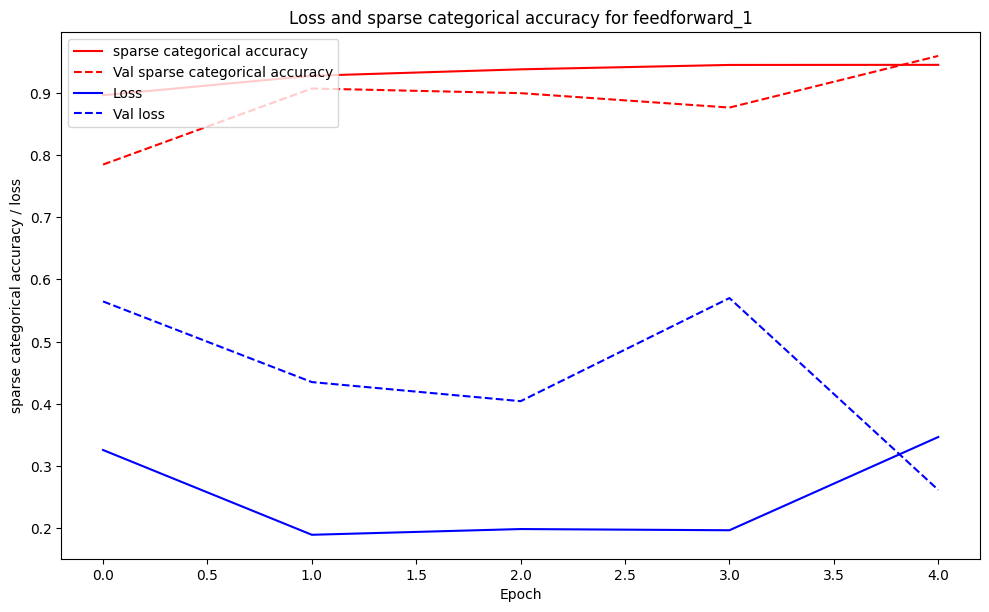

In [82]:
plot_training_loss_and_metric(history, model_identifier)


In [ ]:
# # Otwórz plik do dopisywania (append)
# with open(f"{parent_dir}/TEAA/teaa4_models_results.csv", "a") as file:
#     file.write(f"{';'.join(model_identifier.split('_'))}")
#     file.write()



In [ ]:
drive.flush_and_unmount()